# 1. Linear Classifiers (logistic regression and GDA)

# (b) Implement Newton's method for logistic regression
#### First version

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# df_X = pd.read_csv('http://cs229.stanford.edu/ps/ps1/logistic_x.txt', sep='\ +', header=None, engine='python')
# ys = pd.read_csv('http://cs229.stanford.edu/ps/ps1/logistic_y.txt', sep='\ +', header=None, engine='python')
df_X = pd.read_csv('./data/logistic_x.txt', sep='\ +', header=None, engine='python')
ys = pd.read_csv('./data/logistic_y.txt', sep='\ +', header=None, engine='python')
ys = ys.astype(int)

In [3]:
df_X['label'] = ys[0].values

In [4]:
df_X.head()

0         1  label
0  1.343250 -1.331148     -1
1  1.820553 -0.634668     -1
2  0.986321 -1.888576     -1
3  1.944373 -1.635452     -1
4  0.976734 -1.353315     -1

Quick look at the data

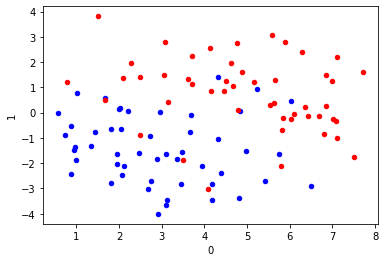

In [5]:
ax = plt.axes()

df_X.query('label == -1').plot.scatter(x=0, y=1, ax=ax, color='blue')
df_X.query('label == 1').plot.scatter(x=0, y=1, ax=ax, color='red');

In [6]:
Xs = df_X[[0, 1]].values

In [7]:
Xs.shape

(99, 2)

In [8]:
# adding a columns of ones for the intercept terms, and also use column vectors
Xs = np.hstack([np.ones((Xs.shape[0], 1)), Xs])
ys = df_X['label'].values

In [9]:
all_thetas = [] # collect for demonstration purpose
theta = np.zeros(Xs.shape[1])
tol = 1e9
n_iters = 0
while tol > 1e-6:
    zs = ys * Xs.dot(theta)
    gzs = 1 / (1 + np.exp(-zs))
    nabla = np.mean((gzs - 1) * ys * Xs.T, axis=1)
    
    # Refactor, more efficient way of calculating hessian
    hessian = np.zeros((Xs.shape[1], Xs.shape[1]))
    for i in range(hessian.shape[0]):
        for j in range(hessian.shape[0]):
            if i <= j:
                hessian[i][j] = np.mean(gzs * (1 - gzs) * Xs[:,i] * Xs[:,j])
                if i != j:
                    hessian[j][i] = hessian[i][j]
            
    delta = np.linalg.inv(hessian).dot(nabla)
    old_theta = theta.copy()
    theta -= delta
    all_thetas.append(theta.copy())
    n_iters += 1
    tol = np.sum(np.abs(theta - old_theta))
print('converged after {0} iterations'.format(n_iters))

converged after 7 iterations


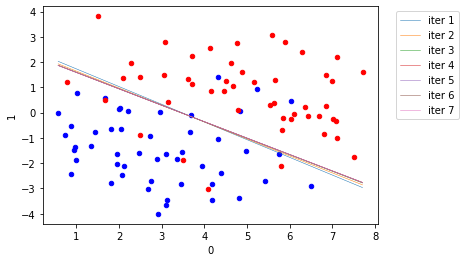

In [10]:
ax = plt.axes()

df_X.query('label == -1').plot.scatter(x=0, y=1, ax=ax, color='blue')
df_X.query('label == 1').plot.scatter(x=0, y=1, ax=ax, color='red')

_xs = np.array([np.min(Xs[:,1]), np.max(Xs[:,1])])
for k, theta in enumerate(all_thetas):
    _ys = (theta[0] + theta[1] * _xs) / (- theta[2])
    plt.plot(_xs, _ys, label='iter {0}'.format(k + 1), lw=0.5)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Since all the lines are so close to each other, Newton's method converges very quickly, at least for this dataset.

# (b) Implement Newton's method for logistic regression
#### Second version

In [11]:
import numpy as np
import util as util
from linear_model import LinearModel

In [12]:
import numpy as np

class LinearModel(object):
    """Base class for linear models."""

    def sigmoid(self, z):
        return 1. / (1 + np.exp(z)) 

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.
        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.
        Args:
            x: Inputs of shape (m, n).
        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')

In [13]:
class Dataset:
    def __init__(self, train_path, eval_path):
        self.x_train, self.y_train = util.load_dataset(train_path, add_intercept=False)
        self.x_val, self.y_val = util.load_dataset(eval_path, add_intercept=False)
        self.x_train_intercept, self.y_train_intercept = util.load_dataset(train_path, add_intercept=True)
        self.x_val_intercept, self.y_val_intercept = util.load_dataset(eval_path, add_intercept=True)
        
ds1 = Dataset('data/ds1_train.csv', 'data/ds1_valid.csv')
ds2 = Dataset('data/ds2_train.csv', 'data/ds2_valid.csv')

Let's take a look at the two training sets:

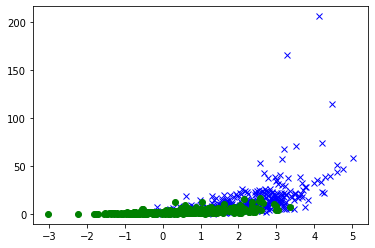

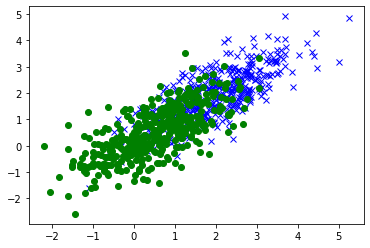

In [14]:
util.plot(ds1.x_train, ds1.y_train)
util.plot(ds2.x_train, ds2.y_train)

Implement functions to compute $h_\theta$, and the gradient and hessian of the loss function $J(\theta)$:

In [15]:
def h(theta, x):
    """vectorized implementation of h_theta(x)
    Args:
        theta: Shape (n,)
        x: Shape (m,n)
    
    Returns:
        numpy array of shape (m,)
    """
    return 1/(1+np.exp(-np.dot(x,theta)))

In [16]:
def gradient(x,y, theta):
    """
    Args:
        x: numpy array of shape (m,n)
        y: numpy array of shape (m,)
        theta: numpy array of shape (n,)
        
    """
    m, = y.shape
    return -1/m * np.dot(x.T, y - h(theta, x))

In [17]:
def hessian(x,y, theta):
    """
    Args:
        x: numpy array of shape (m,n)
        y: numpy array of shape (m,)
        theta: numpy array of shape (n,)
        
    """  
    m, = y.shape
    htx = np.reshape(h(theta,x), (-1,1))
    return 1/m * np.dot(x.T, x*htx*(1-htx))

Now we can define our logistic regression model:

In [18]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def nexttheta(theta):
            grad = gradient(x,y,theta)
            H = hessian(x,y,theta)
            H_inv = np.linalg.inv(H)
            return theta - np.dot(H_inv, grad)
        
        
        m,n = x.shape
        theta_prev = np.zeros(n)
        theta_next = nexttheta(theta_prev)
        
        while np.linalg.norm(theta_prev - theta_next, 1) > self.eps:
            theta_prev = theta_next
            theta_next = nexttheta(theta_prev)
            
        self.theta = theta_next
        
        
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return (x @ self.theta) >= 0
        # *** END CODE HERE ***

Define a classifier and train it on our training data:

In [19]:
logreg1 = LogisticRegression()
logreg1.fit(ds1.x_train_intercept, ds1.y_train_intercept)

Finally, let's plot the decision boundary on the training set and on the validation set:

theta for dataset1: [-2.40859977  1.03437317  0.24480705]


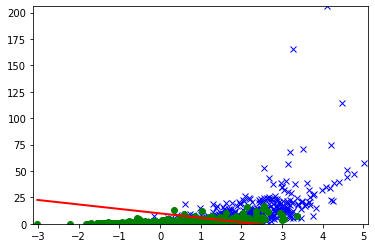

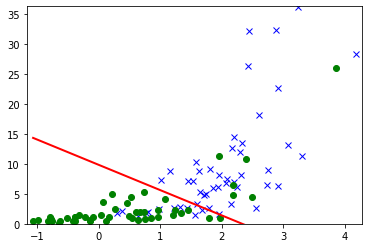

In [20]:
print("theta for dataset1:", logreg1.theta)
util.myplot(ds1.x_train, ds1.y_train, logreg1.theta)
util.myplot(ds1.x_val, ds1.y_val, logreg1.theta)

Let's do the same for dataset2:

theta for dataset2: [-2.09728529  0.86658136  0.82840081]


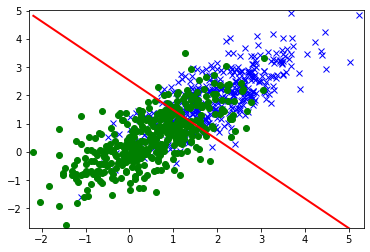

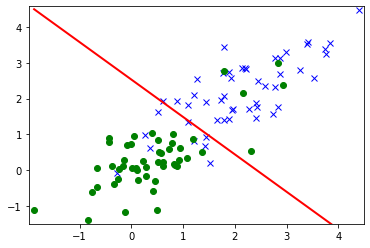

In [21]:
logreg2 = LogisticRegression()
logreg2.fit(ds2.x_train_intercept,ds2.y_train_intercept)

print("theta for dataset2:", logreg2.theta)
util.myplot(ds2.x_train, ds2.y_train, logreg2.theta)
util.myplot(ds2.x_val, ds2.y_val, logreg2.theta)

# (e) Implement GDA model

In [22]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        # Find phi, mu_0, mu_1, and sigma
        # Write theta in terms of the parameters
        
        m,n = x.shape
        y_vec = np.reshape(y,(-1,1))
        
        phi= 1/m * np.sum(y)
        mu_0 = np.sum(x*(1-y_vec), axis= 0) / np.sum(1-y)
        mu_1 = np.sum(x*y_vec, axis=0) / np.sum(y)
        mu_x = y_vec*mu_1 +(1-y_vec)*mu_0 # shape (m,n)
        x_norm = x-mu_x
        sigma = 1/m * np.dot(x_norm.T, x_norm)
        
        sigma_inv = np.linalg.inv(sigma)
        
        theta = -np.dot(sigma_inv,mu_0 - mu_1)
        theta0 = np.array([1/2* mu_0 @ sigma_inv @ mu_0 -1/2* mu_1 @ sigma_inv @ mu_1 -np.log((1-phi)/phi)])
        self.theta = np.concatenate((theta0, theta))
        
        return self.theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        x_intercept = util.add_intercept(x)
        #return 1/ (1+ np.exp(-x_intercept @ self.theta))
        return x_intercept @ self.theta >= 0
        # *** END CODE HERE

Let's train a GDA classifier for dataset 1 and plot the learned decision boundary on the training and the validation set.

theta for dataset1: [-2.10437509  1.59905448  0.01081916]


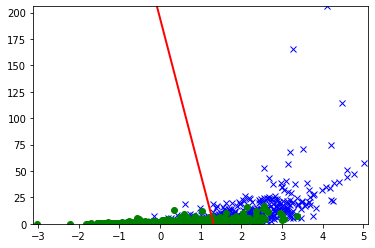

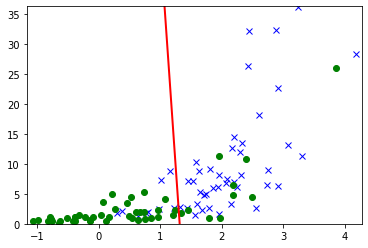

In [23]:
gda1 = GDA()
gda1.fit(ds1.x_train, ds1.y_train)

util.myplot(ds1.x_train,ds1.y_train, gda1.theta)
util.myplot(ds1.x_val,ds1.y_val, gda1.theta)
print("theta for dataset1:",gda1.theta)

The same for dataset 2:

theta for dataset2 [-2.11390101  0.85879252  0.84927843]


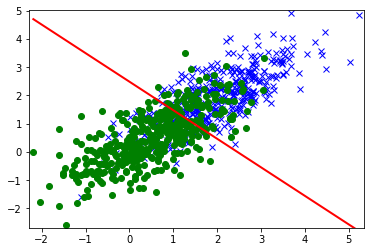

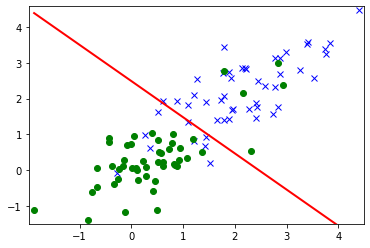

In [24]:
gda2 = GDA()
gda2.fit(ds2.x_train, ds2.y_train)

util.myplot(ds2.x_train,ds2.y_train, gda2.theta)
util.myplot(ds2.x_val, ds2.y_val, gda2.theta)
print("theta for dataset2" ,gda2.theta)

# (f)
#### Decision boundaries on dataset 1 (Logistic regression in red, GDA in black):

theta for logistic regression: [-2.40859977  1.03437317  0.24480705]
                theta for GDA: [-2.10437509  1.59905448  0.01081916]


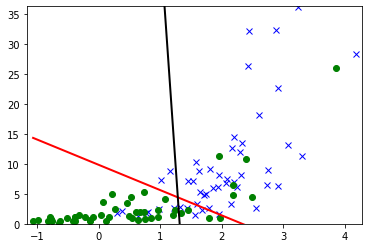

In [25]:
util.myplot_1(ds1.x_val, ds1.y_val, logreg1.theta, gda1.theta)
print("theta for logistic regression:",logreg1.theta)
print("                theta for GDA:", gda1.theta)

# (g)
#### Decisionboundaries on dataset 2 (Logistic regression in red, GDA in black):

theta for logistic regression: [-2.09728529  0.86658136  0.82840081]
                theta for GDA: [-2.11390101  0.85879252  0.84927843]


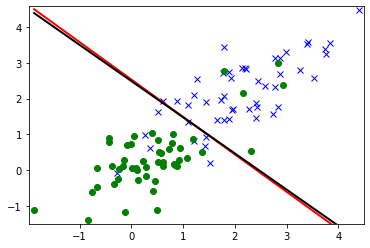

In [27]:
util.myplot_1(ds2.x_val, ds2.y_val, logreg2.theta, gda2.theta)
print("theta for logistic regression:",logreg2.theta)
print("                theta for GDA:", gda2.theta)

To compare the models, let's compute their accuracies:

In [28]:
def accuracy(clf, x_val, y_val):
    y_pred = clf.predict(x_val)
    #print(y_pred)
    correct = np.sum(y_pred == y_val)
    total = y_val.shape[0]
    return correct / total

In [29]:
logreg1_acc = accuracy(logreg1, ds1.x_val_intercept, ds1.y_val)
logreg2_acc = accuracy(logreg2, ds2.x_val_intercept, ds2.y_val)
gda1_acc = accuracy(gda1, ds1.x_val, ds1.y_val)
gda2_acc = accuracy(gda2, ds2.x_val, ds2.y_val)

print("Accuracies on dataset 1:")
print("Logistic regression:", logreg1_acc)
print("                GDA:", gda1_acc)
print("********************************")
print("Accuracies on dataset 2:")
print("Logistic regression:", logreg2_acc)
print("                GDA:", gda2_acc)

Accuracies on dataset 1:
Logistic regression: 0.83
                GDA: 0.81
********************************
Accuracies on dataset 2:
Logistic regression: 0.86
                GDA: 0.86


So while both logistic regression and GDA seem to have the same performance on dataset 2, GDA performs worse on dataset 1.

The reason for this is that dataset 1 doesn't fit the model assumptions of GDA as well as dataset 2, i.e. the data in dataset 1 does not fit well to a multivariate gaussian distribution.

# (h)

Let's have another look at dataset 1:

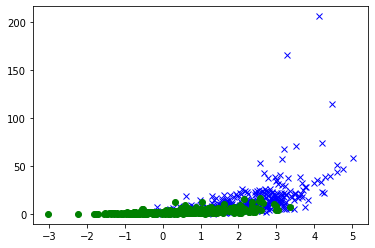

In [30]:
util.plot(ds1.x_train, ds1.y_train)

The $x_2$ values of both classes seem to be positive and there seem to be many values close to $0$. Let's transform the data by applying $\log$ to $x_2$ and leaving $x_1$ unchanged.

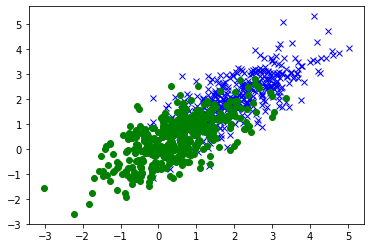

In [43]:
transform = lambda x: np.stack((x[:,0], np.log(x[:,1])), axis=1)

x_train = transform(ds1.x_train)
util.plot(x_train, ds1.y_train)

This looks more or less gaussian. Let's fit a GDA model to the transformed dataset:

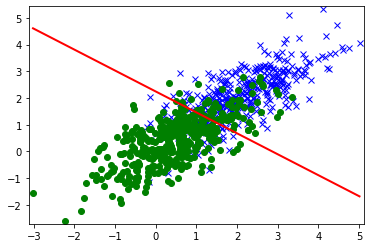

In [44]:
gda3 = GDA()
gda3.fit(x_train, ds1.y_train)
util.myplot(x_train,ds1.y_train, gda3.theta)

Finally let's check if we could improve the accuracy:

In [45]:
x_val = transform(ds1.x_val)
gda3_acc = accuracy(gda3,x_val, ds1.y_val)
print("   GDA accuracy on original dataset1:", gda1_acc)
print("GDA accuracy on transformed dataset1:", gda3_acc)

   GDA accuracy on original dataset1: 0.81
GDA accuracy on transformed dataset1: 0.8


So, it seems that our tranformation didn't change anything to a better side while implementing GDA model, and it's even vice versa. We see that accuracy on the transformed dataset decreased to 0.8 (by -0.01). Maybe it's better to take the initial dataset.

#### Just for fun let's also train a logistic regression model on the transformed dataset and then compare its performance to our previous GDA model.

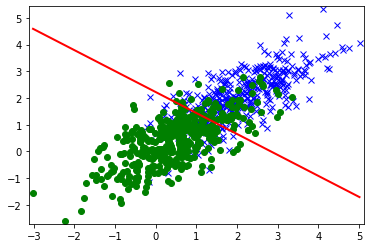

In [46]:
logreg3 = LogisticRegression()
x_train_intercept = util.add_intercept(x_train)
logreg3.fit(x_train_intercept, ds1.y_train)
util.myplot(x_train,ds1.y_train, logreg3.theta)

In [50]:
x_val_intercept = util.add_intercept(x_val)
logreg3_acc = accuracy(logreg3,x_val_intercept, ds1.y_val)
print("Logistic regression accuracy on transformed dataset1:", logreg3_acc)
print("                GDA accuracy on transformed dataset1:", gda3_acc)

Logistic regression accuracy on transformed dataset1: 0.8
                GDA accuracy on transformed dataset1: 0.8


theta for logistic regression (red): [-2.58444791  0.91202678  1.16333356]
              theta for GDA (black): [-2.52917693  0.88245518  1.12726912]


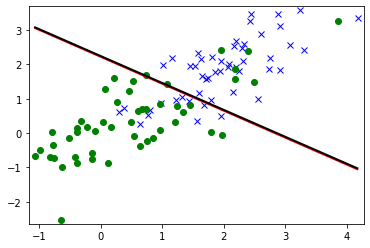

In [51]:
print("theta for logistic regression (red):", logreg3.theta)
print("              theta for GDA (black):",gda3.theta)
util.myplot_1(x_val, ds1.y_val, logreg3.theta, gda3.theta)